<a href="https://colab.research.google.com/github/balnarendrasapa/road-detection/blob/master/submissions/Update%202/Update_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the Repository

[Repository Link](https://github.com/balnarendrasapa/road-detection)

- This is our team's repository. This repository contains all the necessary code that we worked on and it also contains the dataset that we annotated.

- You do not need to do anything like uploading and adjusting the paths. Just run the cells sequentially.

- All the necessary commands are written in this notebook itself

In [1]:
!git clone https://github.com/balnarendrasapa/road-detection.git

Cloning into 'road-detection'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 441 (delta 62), reused 49 (delta 17), pack-reused 259
Receiving objects: 100% (441/441), 204.71 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (155/155), done.


## Install the Requirements

- Install all the python dependencies
- After Installing dependencies, Restart the runtime. If you do not restart the runtime, the python will throw "module not found error"

In [2]:
!pip install -r road-detection/TwinLiteNet/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.4 MB/s 

## Copy Dataset from Repository

- Our repository contains dataset.zip in datasets folder in the repository. copy that zip file to root

In [3]:
!cp road-detection/datasets/dataset.zip ./

## Unzip the file

In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/road_image_160.png  
  inflating: dataset/test/images/road_image_161.png  
  inflating: dataset/test/images/road_image_162.png  
  inflating: dataset/test/images/road_image_163.png  
  inflating: dataset/test/images/road_image_164.png  
  inflating: dataset/test/images/road_image_165.png  
  inflating: dataset/test/images/road_image_166.png  
  inflating: dataset/test/images/road_image_167.png  
  inflating: dataset/test/images/road_image_168.png  
  inflating: dataset/test/images/road_image_169.png  
  inflating: dataset/test/images/road_image_170.png  
  inflating: dataset/test/images/road_image_171.png  
  inflating: dataset/test/images/road_image_172.png  
  inflating: dataset/test/images/road_image_173.png  
  inflating: dataset/test/images/road_image_174.png  
  inflating: dataset/test/images/road_image_175.png  
  inflating: dataset/test/images/road_image_176.png  

## Import the all the required libraries

In [5]:
import torch
import cv2
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import os
import random
import math
from matplotlib import pyplot as plt
import torch.nn as nn

## Image transformation functions

- By paper author

In [6]:
def augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """change color hue, saturation, value"""
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [7]:
def random_perspective(combination,  degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    """combination of img transform"""
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]
    img, gray, line = combination
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpPerspective(gray, M, dsize=(width, height), borderValue=0)
            line = cv2.warpPerspective(line, M, dsize=(width, height), borderValue=0)
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpAffine(gray, M[:2], dsize=(width, height), borderValue=0)
            line = cv2.warpAffine(line, M[:2], dsize=(width, height), borderValue=0)



    combination = (img, gray, line)
    return combination

## Custom Dataset Class

- This custom dataset class is based on the dataset class written by the author but with slight modifications like path. we have adjusted the path according to the google colab.

In [8]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, transform=None, valid=False, test=False):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        :param transform: Type of transformation. SEe Transforms.py for supported transformations
        '''

        self.transform = transform
        self.Tensor = transforms.ToTensor()
        self.valid=valid
        if valid:
            self.root='dataset/validation/images'
            self.names=os.listdir(self.root)
        elif test:
            self.root='dataset/test/images'
            self.names=os.listdir(self.root)
        else:
            self.root='dataset/train/images/'
            self.names=os.listdir(self.root)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        W_=640
        H_=360
        image_name=os.path.join(self.root,self.names[idx])

        image = cv2.imread(image_name)
        original_image = cv2.imread(image_name)
        label1 = cv2.imread(image_name.replace("images","segments").replace("jpg","png"), 0)
        label2 = cv2.imread(image_name.replace("images","lane").replace("jpg","png"), 0)
        if not self.valid:
            if random.random()<0.5:
                combination = (image, label1, label2)
                (image, label1, label2)= random_perspective(
                    combination=combination,
                    degrees=10,
                    translate=0.1,
                    scale=0.25,
                    shear=0.0
                )
            if random.random()<0.5:
                augment_hsv(image)
            if random.random() < 0.5:
                image = np.fliplr(image)
                label1 = np.fliplr(label1)
                label2 = np.fliplr(label2)

        label1 = cv2.resize(label1, (W_, H_))
        label2 = cv2.resize(label2, (W_, H_))
        image = cv2.resize(image, (W_, H_))

        _,seg_b1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY_INV)
        _,seg_b2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY_INV)
        _,seg1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY)
        _,seg2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY)

        seg1 = self.Tensor(seg1)
        seg2 = self.Tensor(seg2)
        seg_b1 = self.Tensor(seg_b1)
        seg_b2 = self.Tensor(seg_b2)
        seg_da = torch.stack((seg_b1[0], seg1[0]),0)
        seg_ll = torch.stack((seg_b2[0], seg2[0]),0)
        image = image[:, :, ::-1].transpose(2, 0, 1)
        image = np.ascontiguousarray(image)

        return original_image, image_name,torch.from_numpy(image),(seg_da,seg_ll)

## Intialize a dataloader

- Intialize a dataloader with batch size 8

- Intialize train, test, validation datasets.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyDataset(), batch_size = 8, shuffle = True)
test_dataloader = DataLoader(MyDataset(test=True), batch_size = 8, shuffle = True)
val_dataloader = DataLoader(MyDataset(valid=True), batch_size = 8, shuffle = True)

## Display images

- Show first sample of each mini-batch with size 8

dataset/train/images/road_image_14.png
dataset/train/images/road_image_84.png
dataset/train/images/road_image_4.png
dataset/train/images/road_image_138.png
dataset/train/images/road_image_9.png
dataset/train/images/road_image_117.png
dataset/train/images/road_image_139.png
dataset/train/images/road_image_12.png
dataset/train/images/road_image_144.png
dataset/train/images/road_image_80.png
dataset/train/images/road_image_68.png
dataset/train/images/road_image_21.png
dataset/train/images/road_image_85.png
dataset/train/images/road_image_64.png
dataset/train/images/road_image_112.png
dataset/train/images/road_image_104.png
dataset/train/images/road_image_36.png
dataset/train/images/road_image_71.png
dataset/train/images/road_image_100.png
dataset/train/images/road_image_69.png


<Figure size 10000x10000 with 0 Axes>

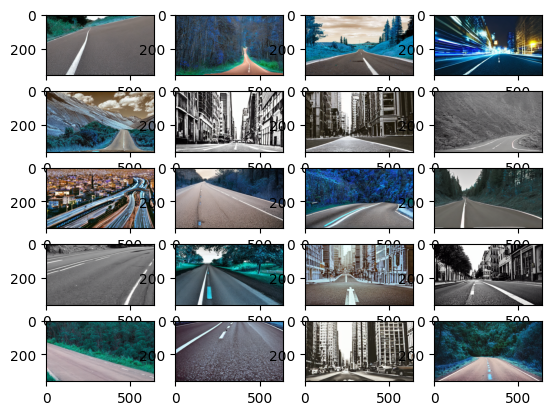

In [10]:
# Printing the first sample of the each minibatch of size 8

plt.figure(figsize = (100, 100))

f, axarr = plt.subplots(5, 4)
i = 0
j = 0

for batch in train_dataloader:
  original_image, image_name, input, target = batch
  print(image_name[0])
  axarr[i, j].imshow(original_image[0])
  j += 1
  if j%4 == 0:
    i += 1
    j = 0

plt.show()

## Copy the required files from the repository to Root

In [11]:
# Copy pretrained model from repository to root
!cp road-detection/TwinLiteNet/pretrained/best.pth ./

# Copy pytorch Neural Net from repo to root
!cp road-detection/TwinLiteNet/model/TwinLite.py ./

# Copy Loss function pytorch code from repo to root
!cp road-detection/TwinLiteNet/loss.py ./

# Copy all reqired constants from repo to root
!cp road-detection/TwinLiteNet/const.py ./

# Copy all val.py from repo to root
!cp road-detection/TwinLiteNet/val.py ./

## Load the pretrained model

In [22]:
import TwinLite as net


model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('best.pth'))


<All keys matched successfully>

## Intialize loss and optimizer.

- This is based on the original code from paper author

In [23]:
from tqdm import tqdm
from loss import TotalLoss

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

criteria = TotalLoss()

In [24]:
args = dict()

args["lr"] = lr
args["max_epochs"] = 8
args["onGPU"] = True

In [25]:
args

{'lr': 0.0005, 'max_epochs': 8, 'onGPU': True}

## Intialize Polynomial Learning Rate Scheduler

- By Paper Author

In [26]:
def poly_lr_scheduler(args, optimizer, epoch, power=2):
    lr = round(args["lr"] * (1 - epoch / args["max_epochs"]) ** power, 8)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

## Write a trainer function for each epoch

- By Paper Author

In [27]:
def train(args, train_loader, model, criterion, optimizer, epoch):
    model.train()

    total_batches = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(pbar, total=total_batches, bar_format='{l_bar}{bar:10}{r_bar}')
    j = 0
    avg_train_loss = 0
    for i, (_, _, input, target) in pbar:
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)

        # target=target.cuda()
        optimizer.zero_grad()

        focal_loss,tversky_loss,loss = criterion(output,target)
        avg_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(('%13s' * 1 + '%13.4g' * 3) %
                                     (f'{epoch}/{args["max_epochs"] - 1}', tversky_loss, focal_loss, loss.item()))
        j += 1
    return avg_train_loss/j, loss.item()

## Train the model with custom data and also print the loss

- This loss is based on the paper

In [28]:
print("------------------------------------------")
training_loss_last_batch = []
validation_loss_last_batch = []
for epoch in range(0, args["max_epochs"]):
    print(f"Epoch: {epoch + 1}/{args['max_epochs']}")
    poly_lr_scheduler(args, optimizer, epoch)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Learning rate: " +  str(lr))
    print()

    # train for one epoch
    model.train()
    avg_train_loss, loss_for_last_batch_train = train( args, train_dataloader, model, criteria, optimizer, epoch)
    model.eval()

    avg_val_loss = 0
    i = 0
    for batch in val_dataloader:
        _, _, input, target = batch
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)
        focal_loss, tversky_loss, loss = criteria(output, target)
        avg_val_loss += loss.item()
        i += 1

    print()
    print(f"Average Training Loss: {avg_train_loss}")
    print(f"Average Validation Loss: {avg_val_loss/i}")
    print()
    print(f"Training loss for last batch: {loss_for_last_batch_train}")
    print(f"Validation loss for last batch: {loss.item()}")
    print("------------------------------------------")
    training_loss_last_batch.append(loss_for_last_batch_train)
    validation_loss_last_batch.append(loss.item())


------------------------------------------
Epoch: 1/8
Learning rate: 0.0005



          0/7        0.222      0.07909       0.3011: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]



Average Training Loss: 0.3648047663271427
Average Validation Loss: 0.4019970993200938

Training loss for last batch: 0.3010614514350891
Validation loss for last batch: 0.3186250925064087
------------------------------------------
Epoch: 2/8
Learning rate: 0.00038281



          1/7       0.2265       0.3978       0.6243: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]



Average Training Loss: 0.27321712523698805
Average Validation Loss: 0.23741921285788217

Training loss for last batch: 0.6242949962615967
Validation loss for last batch: 0.2051147073507309
------------------------------------------
Epoch: 3/8
Learning rate: 0.00028125



          2/7       0.1379       0.0653       0.2032: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]



Average Training Loss: 0.23783655129373074
Average Validation Loss: 0.24910839398701987

Training loss for last batch: 0.20320472121238708
Validation loss for last batch: 0.30490168929100037
------------------------------------------
Epoch: 4/8
Learning rate: 0.00019531



          3/7      0.08868      0.05662       0.1453: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s]



Average Training Loss: 0.20502994544804096
Average Validation Loss: 0.21248679359753928

Training loss for last batch: 0.1452968418598175
Validation loss for last batch: 0.26006802916526794
------------------------------------------
Epoch: 5/8
Learning rate: 0.000125



          4/7       0.1031      0.04127       0.1443: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]



Average Training Loss: 0.17369752563536167
Average Validation Loss: 0.1873659392197927

Training loss for last batch: 0.14433443546295166
Validation loss for last batch: 0.19749757647514343
------------------------------------------
Epoch: 6/8
Learning rate: 7.031e-05



          5/7       0.1722      0.08558       0.2578: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]



Average Training Loss: 0.1697356730699539
Average Validation Loss: 0.17160930236180624

Training loss for last batch: 0.2578093111515045
Validation loss for last batch: 0.0932449996471405
------------------------------------------
Epoch: 7/8
Learning rate: 3.125e-05



          6/7      0.04298      0.02539      0.06837: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]



Average Training Loss: 0.15139427669346334
Average Validation Loss: 0.196141317486763

Training loss for last batch: 0.06836998462677002
Validation loss for last batch: 0.17753556370735168
------------------------------------------
Epoch: 8/8
Learning rate: 7.81e-06



          7/7      0.06552       0.0429       0.1084: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]



Average Training Loss: 0.15306502915918827
Average Validation Loss: 0.18538392086823782

Training loss for last batch: 0.10842433571815491
Validation loss for last batch: 0.15328961610794067
------------------------------------------


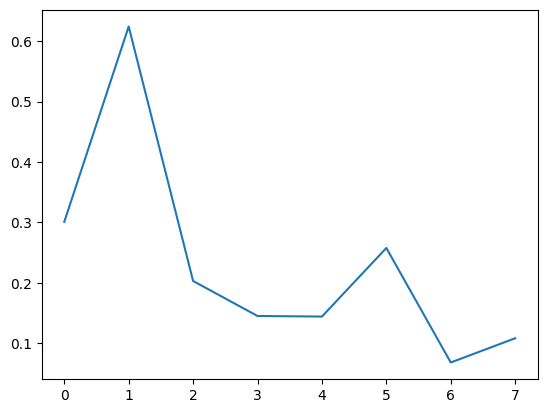

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

x = list(range(len(training_loss_last_batch)))
y = training_loss_last_batch

plt.plot(x, y)

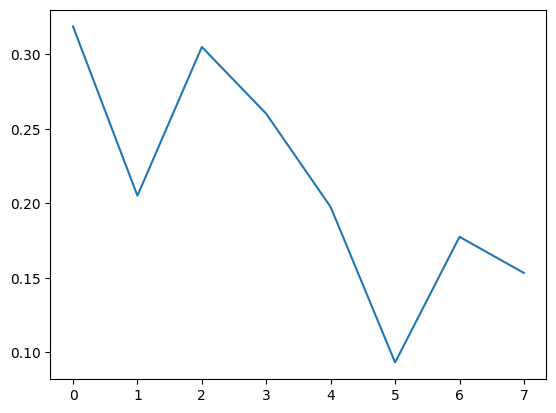

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

x = list(range(len(validation_loss_last_batch)))
y = validation_loss_last_batch

plt.plot(x, y)

## Calculating loss on Test data

In [ ]:
avg_test_loss = 0
i = 0
for batch in test_dataloader:
    _, _, input, target = batch
    if args["onGPU"] == True:
        input = input.cuda().float() / 255.0
    output = model(input)
    focal_loss, tversky_loss, loss = criteria(output, target)
    avg_test_loss += loss.item()
    i += 1

print("------------------------------------------")
print(f"Average Testing Loss: {avg_test_loss/i}")
print(f"Testing loss for last batch: {loss.item()}")
print("------------------------------------------")

------------------------------------------
Average Testing Loss: 0.2197936475276947
Testing loss for last batch: 0.23497554659843445
------------------------------------------


# Defining functions to calculate Pixel Accuracy and Intersection of Union

- by paper author

In [ ]:
class SegmentationMetric(object):
    '''
    imgLabel [batch_size, height(144), width(256)]
    confusionMatrix [[0(TN),1(FP)],
                     [2(FN),3(TP)]]
    '''
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)

    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        # acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc


    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / (self.confusionMatrix.sum(axis=0) + 1e-12)
        return classAcc

    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc)
        return meanAcc

    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        IoU[np.isnan(IoU)] = 0
        mIoU = np.nanmean(IoU)
        return mIoU

    def IntersectionOverUnion(self):
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        IoU[np.isnan(IoU)] = 0
        return IoU[1]

    def genConfusionMatrix(self, imgPredict, imgLabel):
        # remove classes from unlabeled pixels in gt image and predict
        # print(imgLabel.shape)
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix

    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = np.sum(self.confusionMatrix, axis=1) / np.sum(self.confusionMatrix)
        iu = np.diag(self.confusionMatrix) / (
                np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) -
                np.diag(self.confusionMatrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU


    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)

    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [ ]:
@torch.no_grad()
def val(val_loader, model):

    model.eval()


    DA=SegmentationMetric(2)
    LL=SegmentationMetric(2)

    da_acc_seg = AverageMeter()
    da_IoU_seg = AverageMeter()
    da_mIoU_seg = AverageMeter()

    ll_acc_seg = AverageMeter()
    ll_IoU_seg = AverageMeter()
    ll_mIoU_seg = AverageMeter()
    total_batches = len(val_loader)

    total_batches = len(val_loader)
    pbar = enumerate(val_loader)
    pbar = tqdm(pbar, total=total_batches)
    for i, (_, _,input, target) in pbar:
        input = input.cuda().float() / 255.0
            # target = target.cuda()

        input_var = input
        target_var = target

        # run the mdoel
        with torch.no_grad():
            output = model(input_var)

        out_da,out_ll=output
        target_da,target_ll=target

        _,da_predict=torch.max(out_da, 1)
        _,da_gt=torch.max(target_da, 1)

        _,ll_predict=torch.max(out_ll, 1)
        _,ll_gt=torch.max(target_ll, 1)
        DA.reset()
        DA.addBatch(da_predict.cpu(), da_gt.cpu())


        da_acc = DA.pixelAccuracy()
        da_IoU = DA.IntersectionOverUnion()
        da_mIoU = DA.meanIntersectionOverUnion()

        da_acc_seg.update(da_acc,input.size(0))
        da_IoU_seg.update(da_IoU,input.size(0))
        da_mIoU_seg.update(da_mIoU,input.size(0))


        LL.reset()
        LL.addBatch(ll_predict.cpu(), ll_gt.cpu())


        ll_acc = LL.pixelAccuracy()
        ll_IoU = LL.IntersectionOverUnion()
        ll_mIoU = LL.meanIntersectionOverUnion()

        ll_acc_seg.update(ll_acc,input.size(0))
        ll_IoU_seg.update(ll_IoU,input.size(0))
        ll_mIoU_seg.update(ll_mIoU,input.size(0))

    da_segment_result = (da_acc_seg.avg,da_IoU_seg.avg,da_mIoU_seg.avg)
    ll_segment_result = (ll_acc_seg.avg,ll_IoU_seg.avg,ll_mIoU_seg.avg)
    return da_segment_result,ll_segment_result

# Evaluating metrics

In [ ]:
model.eval()
example = torch.rand(1, 3, 360, 640).cuda()
model = torch.jit.trace(model, example)
da_segment_results,ll_segment_results = val(test_dataloader, model)

msg =  'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                    'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})'.format(
                        da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                        ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2])

/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:787: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(
100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [ ]:
print(msg)

Driving area Segment: Acc(0.964)    IOU (0.775)    mIOU(0.867)
Lane line Segment: Acc(0.984)    IOU (0.222)  mIOU(0.603)


# Metrics

- Evaluation metrics are pixel accuracy and IoU(Intersection over Union).
- We have achieved an accuracy of 96.4% for Driving area segment
- We have achieved an accuracy of 98.4% for Lane Line segment.
- An average of 97.4 % pixel accuracy is achieved which is comparable to the original model's accuracy.